In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Define Functions

In [38]:
## SCC functions
from SCC_functions import *

In [39]:
## MACC functions and parameters

# default settings
P_50 = 120  # 187.5 * 0.7625000000000001
P_100 = 300  # 187.5
s = 0.05
r = 0.03

def abatement(P, P0, P_50=P_50, r=r, s=s, P_100=P_100):  # 0.05
    if P0 >= P_50:
        print("P0 is greater than P_50")
    elif ((P_100-P0)/(P_50-P0))**(s/r) <= 2:
        print("MAC curve condition not satisfied")
    
    P_h = P0 + ((P_50 - P0) ** (-s / r) - 2 * (P_100 - P0) ** (-s / r)) ** (-r / s)
    Am = 1 + ((P_100 - P0) / (P_h - P0)) ** (-s / r)
    
    A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
    
    return A

## calculate emissions from forecasted abatement and CO2 baseline

def abatement_to_emissions(forecasted_abatement, CO2_baseline):
    CO2_emissions = CO2_baseline*(1-forecasted_abatement)
    
    return CO2_emissions

# Steps

## 0. Years and Initial Temperature Anomaly

In [40]:
start_year = 2020
end_year = 3000

years = create_years_array(start_year, end_year)
num_of_years = len(years)

In [41]:
## years to calculate SCC
first_perturbed_year = start_year
last_perturbed_year = 2500
year_of_perturbation = create_years_array(start_year, last_perturbed_year)

In [42]:
T_0 = 1.2

## 1. Create Unperturbed Temperature Profile

In [43]:
delta_T = 3
alpha = 0.02
T = create_geometric_T(years, T_0=T_0, alpha=alpha, delta_T=delta_T)

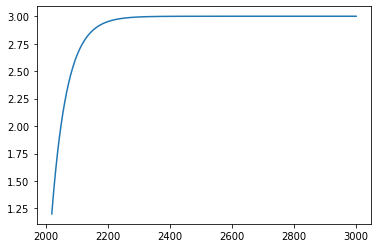

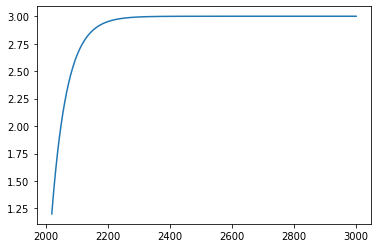

In [44]:
plt.plot(years, T)

## Total Consumption

In [45]:
consumption_growth = 0.02

In [46]:
W = create_total_consumption(years, W_fixed_year=2020, W_fixed=80, consumption_growth=consumption_growth)

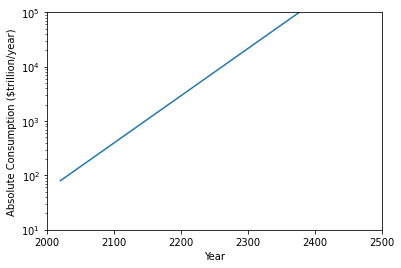

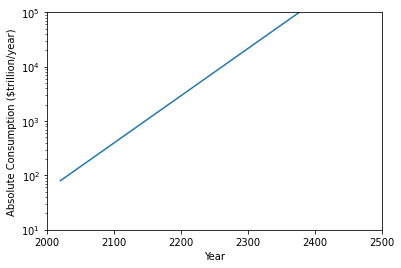

In [47]:
plt.plot(years, W)
plt.xlabel("Year")
plt.ylabel("Absolute Consumption ($trillion/year)")
# plt.xlim(2000, 2100)
# plt.ylim(0, 400)
plt.xlim(2000, 2500)
plt.ylim(10, 100000)
plt.yscale("log")

alternative functional form for above for the fast transition

## 2. Calculate SCC as a function of time for a range of years

In [48]:
T_TCRE_1 = 0.00045
k_s = 0.12
size_of_perturbation = 1

In [49]:
gamma = 2
D0 = 0.00236

In [50]:
# consumption_discount = 0.035
consumption_discount = consumption_growth + 0.015

In [51]:
# consumption_discount = 0.035
# consumption_discount = consumption_growth + 0.015

SCC_list = []

for j in range(len(year_of_perturbation)):
    T_perturbed = create_geometric_T_perturbed(years, T=T, SCC_year=year_of_perturbation[j], T_TCRE=T_TCRE_1*size_of_perturbation, k_s=k_s)   
    discount_function = create_discount_function(years, year_of_perturbation[j], consumption_discount=consumption_discount)
    
    time_series_data = {'years': years, 'W': W, 'discount function': discount_function, 'T': T, 'T perturbed': T_perturbed}

    time_series_df = pd.DataFrame(data=time_series_data).set_index('years')

    SCC = SCC_calculator(time_series_df, size_of_perturbation=size_of_perturbation, gamma=gamma, D0=D0)
    
    if j  == 0:
        print(SCC)
        print(time_series_df)

    if SCC < P_100:
        SCC_list.append(SCC)
    else:
        SCC_list.append(P_100)
        break

23.442601194891857
                  W  discount function         T  T perturbed
years                                                        
2020   8.000000e+01       1.000000e+00  1.200000     1.200000
2021   8.161611e+01       9.656054e-01  1.235642     1.235693
2022   8.326486e+01       9.323938e-01  1.270579     1.270675
2023   8.494692e+01       9.003245e-01  1.304824     1.304960
2024   8.666297e+01       8.693582e-01  1.338391     1.338562
...             ...                ...       ...          ...
2996   2.401697e+10       1.460496e-15  3.000000     3.000450
2997   2.450215e+10       1.410263e-15  3.000000     3.000450
2998   2.499712e+10       1.361758e-15  3.000000     3.000450
2999   2.550210e+10       1.314921e-15  3.000000     3.000450
3000   2.601728e+10       1.269695e-15  3.000000     3.000450

[981 rows x 4 columns]
23.442601194891857
                  W  discount function         T  T perturbed
years                                                        
2020   8

In [52]:
SCC_array = np.asarray(SCC_list)  # convert to numpy array

Text(0, 0.5, 'SCC ($)')

Text(0, 0.5, 'SCC ($)')

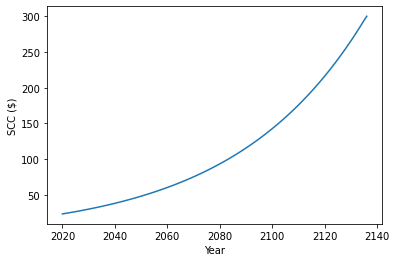

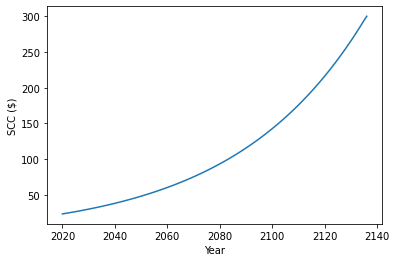

In [53]:
plt.plot(year_of_perturbation[:len(SCC_array)], SCC_array)
plt.xlabel("Year")
plt.ylabel("SCC ($)")

### Check 100% abatement has been achieved!

In [54]:
if SCC_array[-1] < P_100:
    print("P_100 not achieved by achieved by final perturbed year")

In [55]:
SCC_forecasted = []

for i in range(num_of_years):
    if i < len(SCC_array):
        SCC_forecasted.append(SCC_array[i])
    else:
#         SCC_forecasted.append(SCC_array[-1])
        SCC_forecasted.append(P_100)

SCC_forecasted = np.array(SCC_forecasted)

In [56]:
# SCC_forecasted

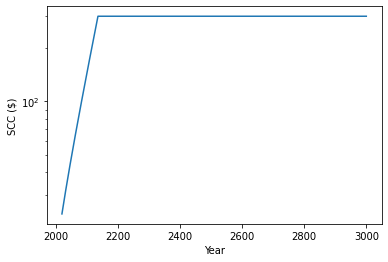

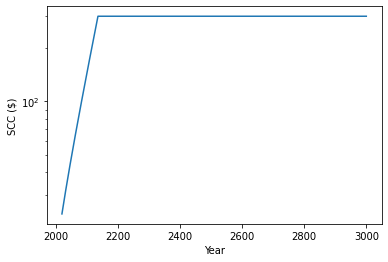

In [57]:
plt.plot(years, SCC_forecasted)
plt.xlabel("Year")
plt.ylabel("SCC ($)")
plt.yscale("log")

## 3. Abatement as a function of time

In [58]:
P0 = SCC_forecasted[0]

In [59]:
forecasted_abatement = abatement(P=SCC_forecasted, P0=P0)  # , r=consumption_discount

/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_32650/2947447235.py:18: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_32650/2947447235.py:18: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


problems with certain values due to constraints of the model

Text(0, 0.5, 'Abatement')

Text(0, 0.5, 'Abatement')

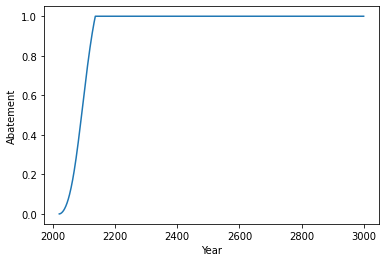

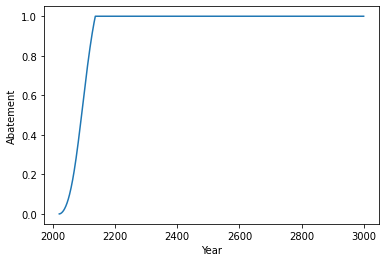

In [60]:
plt.plot(years, forecasted_abatement)
plt.xlabel("Year")
plt.ylabel("Abatement")

## 4. Abatement to emissions

In [61]:
CO2_baseline = 40

In [62]:
forecasted_emissions = abatement_to_emissions(forecasted_abatement, CO2_baseline)

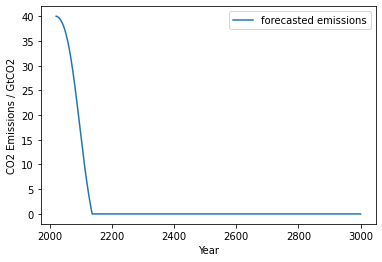

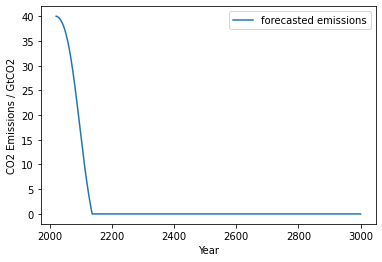

In [63]:
# plt.plot(ssp245_CO2_past, label="historical emissions")
plt.plot(years, forecasted_emissions, label="forecasted emissions")
plt.xlabel("Year")
plt.ylabel("CO2 Emissions / GtCO2")
plt.legend()

## 5. Cumulative Emissions to Temperature Change

In [64]:
cumulative_emissions_array = np.append(np.zeros(1), np.cumsum(forecasted_emissions)[:-1])

In [65]:
temperature_change = T_TCRE_1*cumulative_emissions_array

In [66]:
max(temperature_change)

1.269924259682393

1.269924259682393

In [67]:
T_forecast_iteration0 = T_0 + temperature_change
# T_forecast_iteration0_plateau = T_2019 + temperature_change_plateau

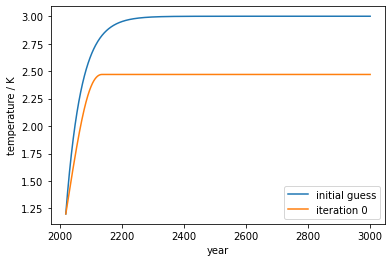

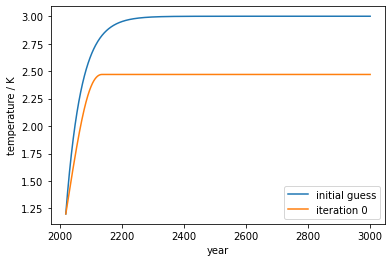

In [68]:
plt.plot(years, T, label="initial guess")
plt.plot(years, T_forecast_iteration0, label="iteration 0")
# plt.plot(T_forecast_years, T_forecast_iteration0_plateau, label="iteration 0 plateau")
plt.xlabel("year")
plt.ylabel("temperature / K")
plt.legend()

# Iterating Further

In [69]:
# T_forecast_first_loop = T_forecast_iteration0_plateau
# T_forecast_iteration = T_forecast_iteration0_plateau

In [70]:
T_forecast_first_loop = T_forecast_iteration0
T_forecast_iteration = T_forecast_iteration0

20.401539384630915
20.401539384630915


/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_32650/2947447235.py:18: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_32650/2947447235.py:18: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


20.849250552289224
20.849250552289224


/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_32650/2947447235.py:18: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_32650/2947447235.py:18: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


20.727636399469283
20.727636399469283


/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_32650/2947447235.py:18: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_32650/2947447235.py:18: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


20.761229673595825
20.761229673595825
3
3


/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_32650/2947447235.py:18: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_32650/2947447235.py:18: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


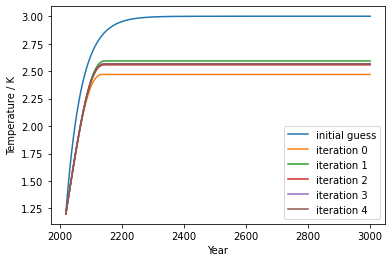

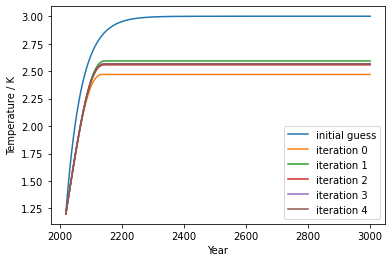

In [71]:
num_of_iterations = 99

first_perturbed_year = start_year

year_of_perturbation = np.arange(first_perturbed_year, last_perturbed_year+1)

plt.plot(years, T, label="initial guess")
plt.plot(years, T_forecast_first_loop, label="iteration 0")

for k in range(num_of_iterations):
#     T_iteration = np.concatenate([T_gas_df['CO2_best'],T_forecast_iteration[1:]])

    SCC_list = []

    for j in range(len(year_of_perturbation)):

        T_perturbed = create_geometric_T_perturbed(years, T=T_forecast_iteration, SCC_year=year_of_perturbation[j], T_TCRE=T_TCRE_1*size_of_perturbation, k_s=k_s)
        discount_function = create_discount_function(years, year_of_perturbation[j], consumption_discount=consumption_discount)

        time_series_data = {'years': years, 'W': W, 'discount function': discount_function, 'T': T_forecast_iteration, 'T perturbed': T_perturbed}
        time_series_df = pd.DataFrame(data=time_series_data).set_index('years')

        SCC = SCC_calculator(time_series_df, size_of_perturbation=size_of_perturbation, gamma=gamma, D0=D0)

        if j  == 0:
            print(SCC)

        if SCC < P_100:
            SCC_list.append(SCC)
        else:
            SCC_list.append(P_100)
            break

    SCC_array = np.asarray(SCC_list)

    SCC_forecasted = []

    for i in range(num_of_years):
        if i < len(SCC_array):
            SCC_forecasted.append(SCC_array[i])
        else:
            SCC_forecasted.append(P_100)

    SCC_forecasted = np.array(SCC_forecasted)

    P0 = SCC_forecasted[0]

    forecasted_abatement = abatement(P=SCC_forecasted, P0=P0)
    forecasted_emissions = abatement_to_emissions(forecasted_abatement, CO2_baseline)

    cumulative_emissions_array = np.append(np.zeros(1), np.cumsum(forecasted_emissions)[:-1])

    temperature_change = T_TCRE_1*cumulative_emissions_array
    
    T_forecast_iteration = T_0 + temperature_change
    
    plt.plot(years, T_forecast_iteration, label="iteration "+str(k+1))
    
    if k == 0:
        peak_T = max(T_forecast_iteration)
    else:
        previous_peak_T = peak_T
        peak_T = max(T_forecast_iteration)
        if abs(peak_T - previous_peak_T) < 0.005:
            print(k)
            break
    
    if k == num_of_iterations - 1:
        print("convergence condition not achieved")
        print(f"{consumption_discount=}")
        print(f"{consumption_growth=}")
        print(f"{P_50=}")
        print(f"{s=}")
        print(f"{r=}")
        print(f"{P_100=}")

plt.xlabel("Year")
plt.ylabel("Temperature / K")
plt.legend()

***this is fairly analogous to the Newton-Raphson Method***
- the initial temperature profile is essentially just a starting guess; getting pushed toward temperature profile solution
- could stop the iterations when the difference between two consecutive lines is small

In [72]:
## peak Temperature
max(T_forecast_iteration)

2.5645923835913385

2.5645923835913385

under default settings: 2.5645923835913385

using alternate pulse: 2.5696260200656615